# GİRİŞ

Günümüzde şirketlerin pazarlama harcamalarını azaltabilmesi ve karı artırabilmesi için pazarlama stratejilerinin doğru geliştirmesi gerekir. 
Bu anlamda müşteri profillerinin analiz edilmesi doğru stratejiler geliştirmek için yapılması gerekenlerden biridir.

### Veri Seti Hakkında Bilgi
Bu projede kullanılan veri seti, Porketiz bankacılık kurumunun doğrudan pazarlama departmanından gelmektedir. Kampanya, banka müşterilerinin vadeli mevduat hesabı açtırmalarına yöneliktir. 
Veri setinde müşterilerin bilgileri ve bu kampanya sonucu vadeli mevduat hesabı açtırıp açtırmadıklarının (evet/hayır) bilgileri bulunmaktadır.

Orijinal veri setinin kaynağı: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

Bu projede kullanılan veri setinin kaynağı: https://www.kaggle.com/yufengsui/portuguese-bank-marketing-data-set
### Problem
Bu projede ana amaç, bankanın müşteri hizmetlerinin bir müşteriyi aramadan önce kampanyaya vereceği cevabı(evet/hayır) tahmin edebilmektir.
### Metodoloji
1. Veri Keşifi
2. Veri Görselleştirme
3. Veri Hazırlama
4. Matematiksel Modelleme
5. Sonuçlar

# VERİ KEŞİFİ

In [38]:
#Kütüphanelerin yüklenmesi :
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sb
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from warnings import filterwarnings
filterwarnings('ignore')

### Veri setinin yüklenmesi

In [39]:
term_deposit_marketing_2020 = pd.read_csv("term_deposit_marketing_2020.csv")
df = term_deposit_marketing_2020.copy()

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


### Değişkenler

**Girdiler:**
- age : yaş (numeric)
- job: meslek (category)
- marital: medeni hal (binary)
- education : eğitim seviyesi (category)
- default : temerrüde düşen kredisi olup olmadığı (binary)
- balance : yıllık ortalama bakiye (numeric)
- housing : ev kredisi olup olmadığı (binary)
- loan : kredisi olup olmadığı (binary)
- contact : müşteri hizmetlerinin iletişim türü (category)
- day : en son iletişim kurulan gün (numeric)
- month : en son iletişim kurulan ay (category)
- duration : en son görüşmede kaç saniye iletişim kurulduğu (numeric)
- campaign : kampanya süresinde kaç kere iletişim kurulduğu  (numeric)

**Çıktı :**
- y : vadeli hesap açtırıp açtırmadığı (binary)

In [40]:
# Değişken çeşitleri
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


Numeric değişkenler: age, balance, day, duration ve campaign                                                                                            
Numeric olmayan değişkenler: job, marital, education, default, housing, loan, contact, month, y

# VERİ GÖRSELLEŞTİRME

In [4]:
# Kampanyaya evet ve hayır diyenlerin yüzdesel dağılımı:
df["y"].value_counts(normalize = True).round(2)

no     0.93
yes    0.07
Name: y, dtype: float64

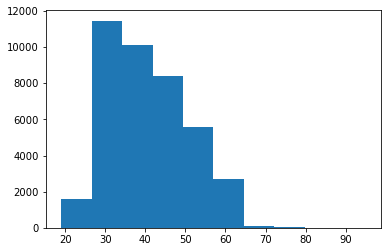

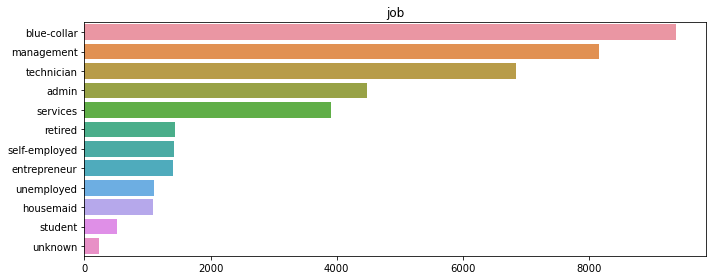

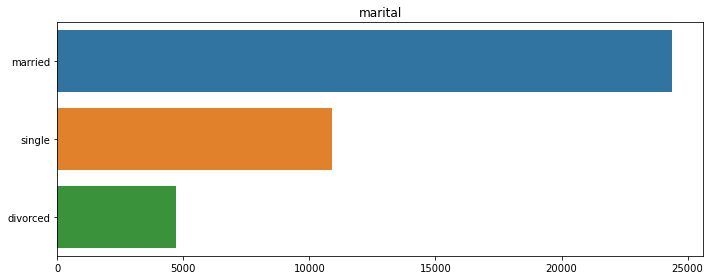

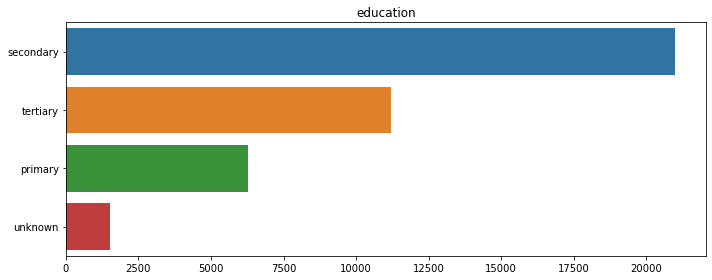

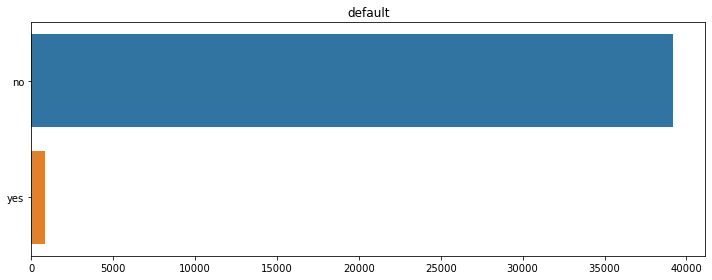

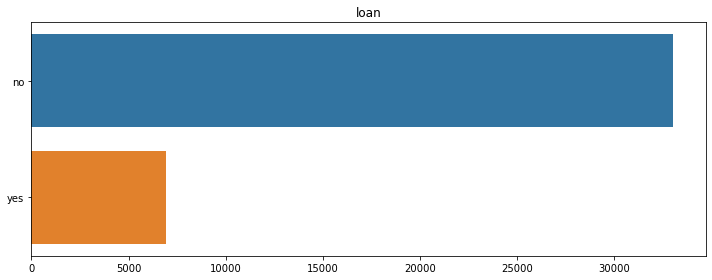

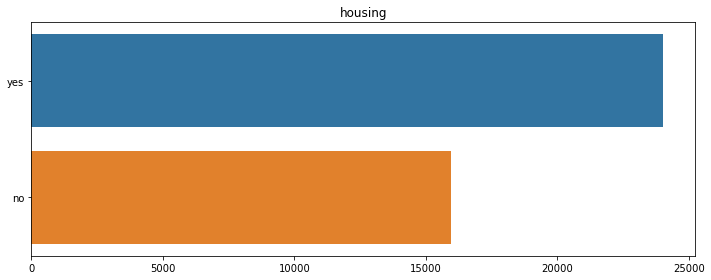

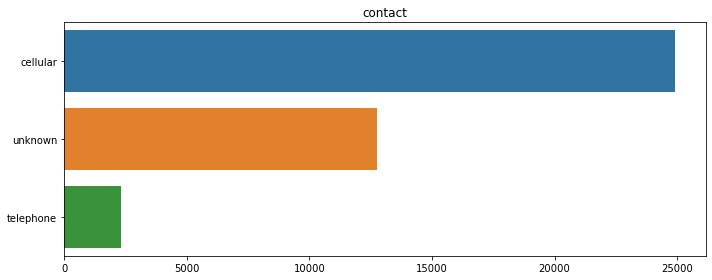

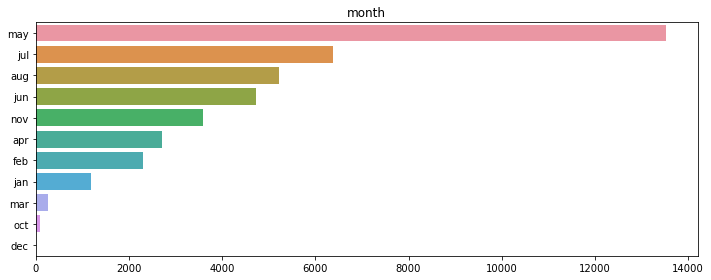

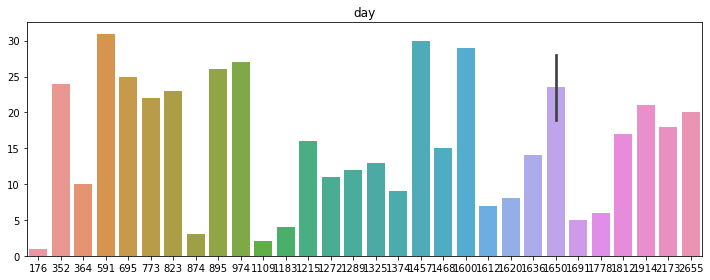

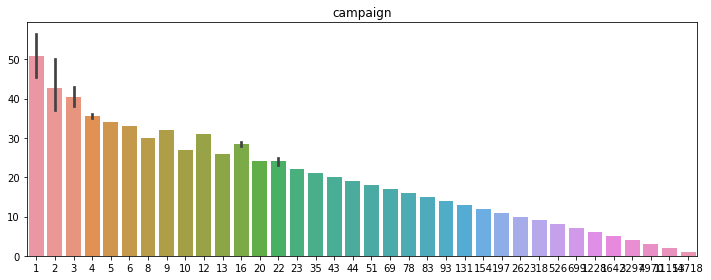

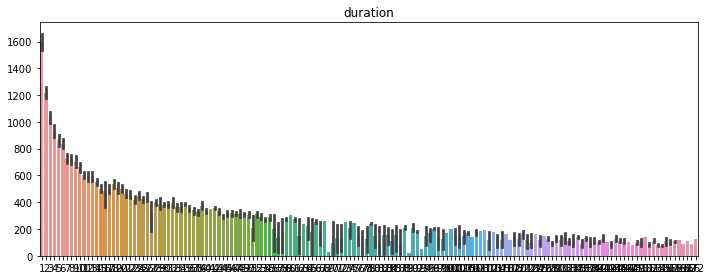

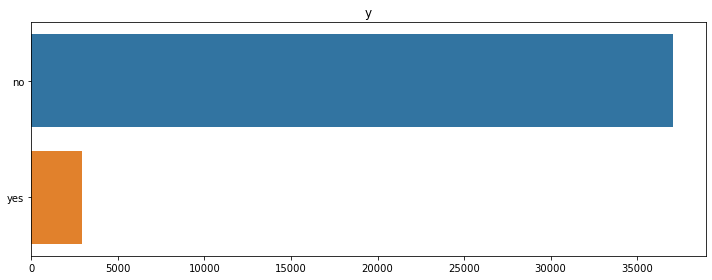

In [5]:
# Değişkenlerin içerdiği unique değerleri ve frekanslarını görmek için histogram grafikleri :
import matplotlib.pyplot as plt

plt.hist(df["age"], bins=10)
plt.show()

categorical_variables = ['job', 'marital', 'education', 'default', 'loan', 'housing','contact', 'month', 'day', 'campaign','duration', 'y']
for col in categorical_variables:
    plt.figure(figsize=(10,4))
    sb.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

### Kampanyaya evet diyen müşteriler hangi özelliklere sahip?

 Temettüye düşen kredisi (default) olmayan,ve kredisi (loan) olmayan müşterilerin genellikle kampanyaya katıldıkları söylenebilir.
 
 30-50 yaş arasındaki müşterilerin kampanyaya daha fazla katıldığı söylenebilir.
 
 En son aramanın süresi(duration) arttıkça evet denilme olasılığı daha çok gözlemlenmiş.


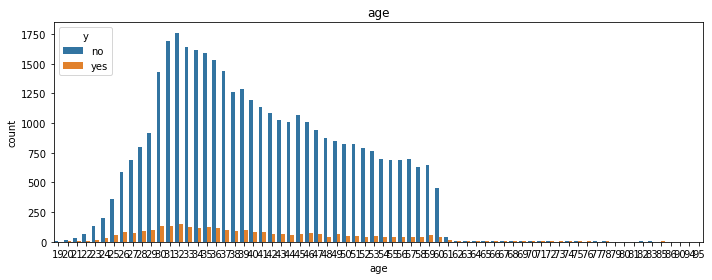

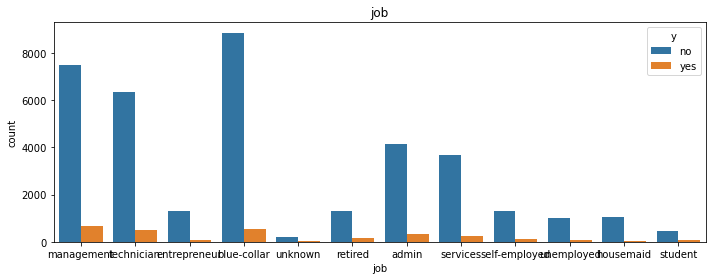

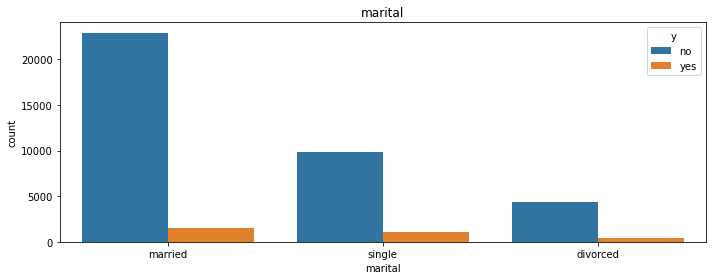

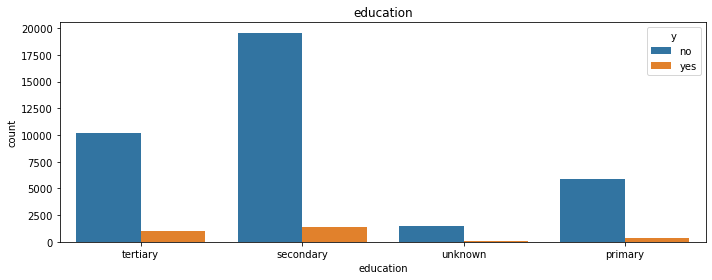

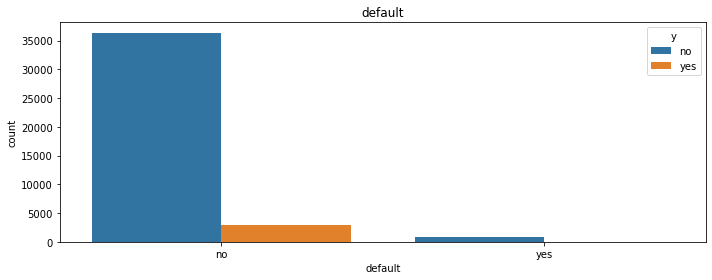

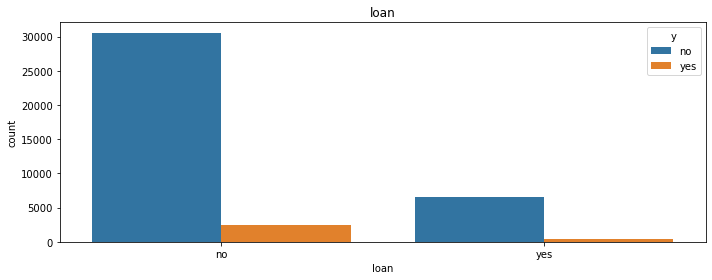

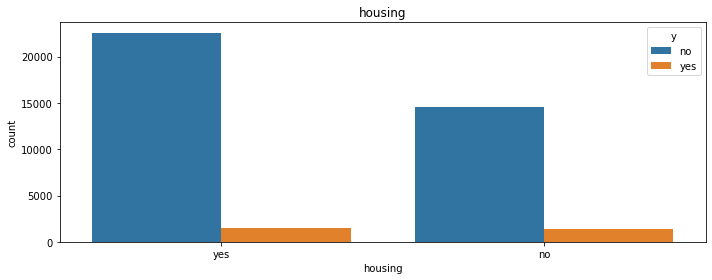

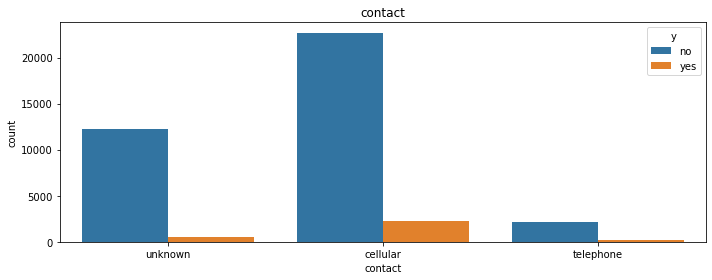

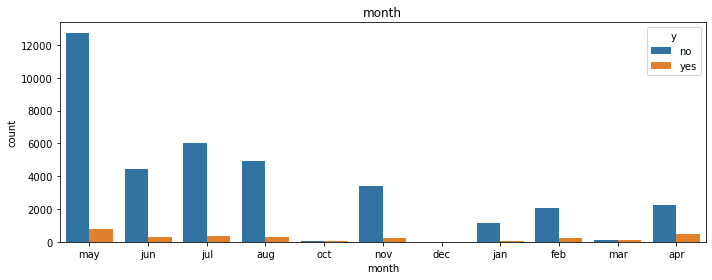

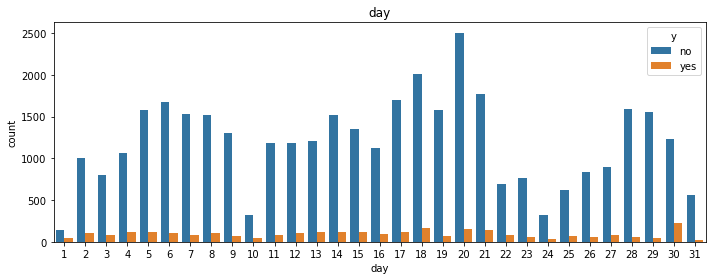

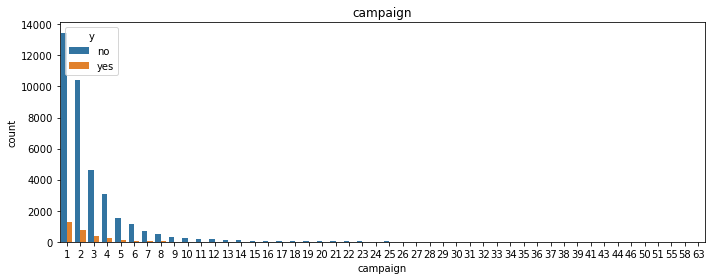

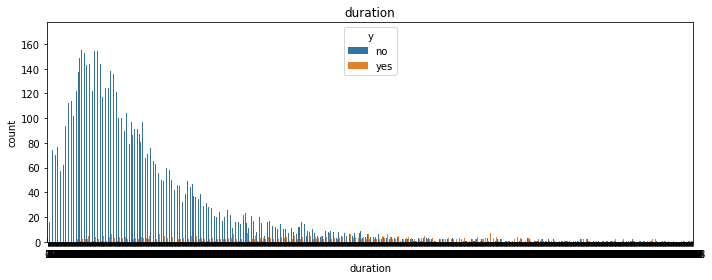

In [6]:
variables = ['age','job', 'marital', 'education', 'default', 'loan', 'housing', 'contact', 'month', 'day', 'campaign', 'duration']
for col in variables:
    plt.figure(figsize=(10,4))
    sb.countplot(df[col], hue=df['y'])
    plt.title(col)
    plt.tight_layout()

###  Korelasyon Analizi

Isı haritası tablosundan görüldüğü üzere duration değişkeni ile müşterilerin kampanyaya yanıtları arasında bir pozitif bir korelasyon vardır.

<AxesSubplot:>

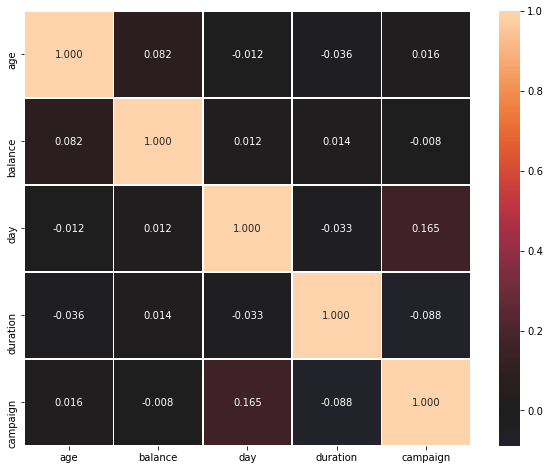

In [7]:
# Isı haritası :
plt.figure(figsize=(10,8))
sb.heatmap(df.corr(), annot=True, fmt='0.3f', center=0,linewidths=.5)

# VERİ TEMİZLEME

### Numeric Değişkenler - Eksik Veri Analizi

Numeric değişkenler : "age", "balance", "day", "duration" ve "campaign" dir.

Eksik değer bulunmamaktadır dolayısıyla eksik değer tamamlama işlemlerini uygulamaya gerek yoktur.

In [8]:
df.isnull().value_counts()

age    job    marital  education  default  balance  housing  loan   contact  day    month  duration  campaign  y    
False  False  False    False      False    False    False    False  False    False  False  False     False     False    40000
dtype: int64

In [9]:
numerical_variables = ["age", "balance", "day", "duration", "campaign"]
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


### Numeric Değişkenler - Aykırı Gözlem Analizi

Aykırı gözlemleri tespit etmek için ilk olarak sınır değerlere göz atılır.

Tablo incelendiğinde numeric değişkenlerinin alt ve üst sınır değerlerinin dışında değerler (outlier) aldığı görülmektedir.

Veri setinin hikayesi düşünüldüğünde bu değerler aykırı gözlem olarak düşünülmedi.

Fakat, müşteriyle en son kurulan iletişimin kaç saniye sürdüğünü ifade eden "duration" değişkeninin 15 saniyenin altında değerler alan gözlemlere değişkenin medyan değeri atandı.

Bunun sebebi mantıklı bir telefon görüşmenin minimum 15 saniye süreceğinin düşünülmesi.

In [10]:
# Alt sınır değer, üst sınır değer, minimum değer ve maksimum değerden oluşan bir tablo oluşturuldu :

numerical_variables = ["age", "balance", "day", "duration", "campaign"]

mp = { 'column': [], 'lower_outer_fence': [], 'upper_outer_fence': [] , 'min_value': [], 'max_value': []}

for column in numerical_variables:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    min_value = df[column].min()
    max_value = df[column].max()
        
    lower_outer_fence = Q1 - 1.5 * IQR
    upper_outer_fence = Q3 + 1.5 * IQR
    
    mp['column'].append(column)
    mp['lower_outer_fence'].append(lower_outer_fence)
    mp['upper_outer_fence'].append(upper_outer_fence)
    mp['min_value'].append(min_value)
    mp['max_value'].append(max_value)
    
pd.DataFrame(mp)

,column,lower_outer_fence,upper_outer_fence,min_value,max_value
0,age,10.5,70.5,19,95
1,balance,-1843.5,3216.5,-8019,102127
2,day,-11.5,40.5,1,31
3,duration,-219.5,632.5,0,4918
4,campaign,-2.0,6.0,1,63


In [11]:
# Aykırı gözlemin medyana eşitlenmesi :

median = df["duration"].median()

df["duration"] = np.where((df["duration"] < 10), median,df['duration'])

### Kategorik Değişken - Eksik Veri Analizi

Veri setinde eksik değer yoktur, fakat "unknown" olarak ifade edilmiş bilinmeyen değerler mevcuttur. 

Unknown gözlemlerin yalnızca "job", "education" ve "contact" değişkenlerinde bulunduğu tespit edilmişti. 
Bu değerler tahmin edilerek değiştirildi.

In [12]:
# Unknown değer içeren değişkenler ve sayısı :
for col in df.columns:
    if df.dtypes[col] == "object":
        print(col, len(df.query("{0} == 'unknown'".format(col))))

job 235
marital 0
education 1531
default 0
housing 0
loan 0
contact 12765
month 0
y 0


### Kategorik Değişken - Eksik Veri Tamamlama

Job değişkeninin eğitim değişkeninden etkilenebileceği düşünülerek ikisi arasında çapraz tablolama yapıldı ve bu tablodan yola çıkılarak unknown değerlere çeşitli atamalar yapıldı.

In [13]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx
cross_tab(df,'job','education')

,tertiary,secondary,unknown,primary
job,,,,
admin,410,3723,148,202
blue-collar,127,5144,439,3673
entrepreneur,648,507,74,176
housemaid,147,345,40,555
management,6667,1037,189,273
retired,229,664,59,485
self-employed,702,552,31,129
services,170,3269,135,336
student,150,282,74,18


Yaşı 60'dan büyük olan müşterilerin çoğunluğu emekli olduğu için;

İşi bilinmeyen ve 60 yaşından büyük olan gözlemlerin job değişkenine "retired" atandı.

In [14]:
# Yaşı 60'dan büyük olan gözlemlerin mesleği :

df['job'][df['age']>60].value_counts()

retired          163
management        22
housemaid         15
technician        10
blue-collar        8
self-employed      6
admin              4
unknown            3
unemployed         2
entrepreneur       1
Name: job, dtype: int64

In [15]:
# Koşulu sağlayan ve job=unknown değerler için atama :
df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'retired'

Her bir job değişkeninine karşılık bilinmeyen education değişkeni için, o iş çeşidinin en çok tekrarlayan eğitim değeri atandı.

Örneğin; job = management için education değişkeninin en çok aldığı değer "tertiary" ise;

job = management ve education= unknown ise education= tertiary 

In [16]:
df.loc[(df['education']=='unknown') & (df['job']=='admin'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='blue-collar'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='entrepreneur'), 'education'] = 'tertiary'
df.loc[(df['education']=='unknown') & (df['job']=='housemaid'), 'education'] = 'primary'
df.loc[(df['education']=='unknown') & (df['job']=='management'), 'education'] = 'tertiary'
df.loc[(df['education']=='unknown') & (df['job']=='retired'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='self-employed'), 'education'] = 'tertiary'
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='student'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='technician'), 'education'] = 'secondary'
df.loc[(df['education']=='unknown') & (df['job']=='unemployed'), 'education'] = 'secondary'

Job ve Education değişkenlerinin ikisi de bilinmeyen gözlemlere her kategorinin en çok tekrar eden değeri atandı.

In [17]:
df.loc[(df['education']=='unknown'), 'education'] = df["education"].mode()
df.loc[(df['job']=='unknown'), 'job'] = df["job"].mode()

Contact değişkenindeki unknown satırlar en çok tekrar eden değere eşitlenir.

In [18]:
df.loc[(df['contact']=='unknown'), 'contact'] = df["contact"].mode()

In [19]:
# Test
((df["job"] =='unknown') | (df["education"] == 'unknown') | (df["contact"] == 'unknown')).value_counts()

False    40000
dtype: int64

### Değişken Türü Değiştirme

Matematiksel modeli kurabilmek için object türündeki değişkenler numeric değerlere dönüştürüldü. 

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df:
    if df[col].dtype == "object":
        df[col]=le.fit_transform(df[col])

### Test ve Train Veri Seti Ayırması

In [21]:
y = df["y"]
X = df.drop(["y"], axis=1)

In [22]:
# Test ve train ayırımı

X_train, X_test, y_train, y_test = train_test_split( df.drop(columns = "y"),
                                                    df.y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify = df.y )


# MATEMATİKSEL MODELLEME

Problemin bir sınıflandırma örneği olmasından dolayı Lojistik Regresyon, ve K Neighbour algoritmaları kullanıldı.

In [23]:
# Kütüphanelerin yüklenmesi :
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import os

### Lojistik Regresyon Modeli

In [24]:
log = LogisticRegression(solver = "liblinear")
log_reg = log.fit(X_train, y_train)
log_reg

LogisticRegression(solver='liblinear')

In [25]:
log_reg_scr_trn = log_reg.score(X_train,y_train)
log_reg_scr_trn

0.9334

In [26]:
log_reg_scr_tst = log_reg.fit(X_test,y_test)

In [27]:
log_reg_scr_tst = log_reg.score(X_test,y_test)
log_reg_scr_tst

0.9315

In [28]:
log_reg = log_reg.predict(X_test)

In [29]:
print(classification_report(log_reg,y_test))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      9727
           1       0.22      0.57      0.31       273

    accuracy                           0.93     10000
   macro avg       0.60      0.76      0.64     10000
weighted avg       0.97      0.93      0.95     10000



### K Nearest Neighbour

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [31]:
knn_scr= knn.score(X_train,y_train)
knn_scr

0.9426333333333333

In [32]:
knn.fit(X_test,y_test)

KNeighborsClassifier()

In [33]:
knn_scr_tst = knn.score(X_test,y_test)
knn_scr_tst

0.9433

In [34]:
knn_pred = knn.predict(X_test)

In [35]:
print(classification_report(knn_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9597
           1       0.39      0.69      0.50       403

    accuracy                           0.94     10000
   macro avg       0.69      0.82      0.73     10000
weighted avg       0.96      0.94      0.95     10000



### Model Değerlendirme

In [36]:
d = {"Model":['Logistic Regression',"K Neighbour"],
     'Training validation':[log_reg_scr_trn,knn_scr], 
     "Test Validation": [log_reg_scr_tst,knn_scr_tst]}


In [37]:
model_evaluation =pd.DataFrame(d)
model_evaluation

,Model,Training validation,Test Validation
0,Logistic Regression,0.933400,0.9315
1,K Neighbour,0.942633,0.9433
